In [ ]:
# This code corresponds to the paper arXiv: 2209.02075

In [1]:
# Specify the local path to the data folder
# The data can be downloaded from https://drive.google.com/drive/folders/1GPLgNqfSUzcJKS4UxOewevg55ujIavOv?usp=sharing
# Note all the datafiles are for z=0.27 but please email me if you need similar data at a different redshift
# or any other data which is not included in this notebook.
path = '/Users/jayw/Documents/Acad/CCA/data/SZ/arxiv_2209.02075/'

In [2]:
import numpy as np
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power
import h5py, os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from matplotlib import pyplot as plt
import scipy, time, multiprocessing
from scipy import interpolate
from scipy.optimize import curve_fit
%matplotlib inline
# import illustris_python as il

# for aesthetic plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=14
plt.rcParams["figure.figsize"] = [6.0,4.]
plt.rcParams["xtick.labelsize"] = 16; plt.rcParams["ytick.labelsize"] = 16
matplotlib.rc('text', usetex=True)

In [3]:
powlaw=np.logspace(-10,30,num=5);
powlaw3=np.logspace(2,5.,num=15);
xh=0.76;

# Scaling Y from Leander's files
# 1e-6 * sigma_T / (me * c^2) * 1e10msun/h / Gyr^2
Yscale= 1e-6 * (6.65e-25) / (9.1e-28 * 3e10**2) * 1.989e43/0.671 / (3.154e16)**2

In [4]:
# For making cumulative profiles
rbinEdges=np.append(0,np.geomspace(0.03, 2.5, num=128)) # radial bins in Leander's code
rbins = (rbinEdges[1:]+rbinEdges[:-1])/2
volBin=4/3.*pi*(rbinEdges[1:]**3-rbinEdges[:-1]**3)

def CumProfile(temp2,r200):
    numHalo=len(temp2)
    
    temp4=temp2.copy()
    for i in range(len(temp4)):
        temp4[i]*=volBin*1e9
        
    temp3=np.zeros((numHalo,128)); temp3[:,0]=temp4[:,0]
    for i in range(1,128):
        temp3[:,i]=temp4[:,i]+temp3[:,i-1]
        
    for i in range(0,numHalo):
        temp3[i]*=r200[i]**3
    return(temp3)

In [100]:
# Specify 'TNG' or 'SIMBA'
key='TNG'

# Specify 'LH' or '1P'
key2='1P'

In [101]:
dire=path+key+'/'+key2
os.chdir(dire)

In [102]:
m200=np.load('M200c.npy') # M200c (all masses are in units of 10^10 Msol/h)
r200=np.load('R200c.npy')/1e3 # R200c (in kpc/h)
yProf = np.load('y_profiles.npy'); # Profiles from Leander's code: y_prof.cpp
neProf = np.load('ne_profiles.npy'); # Profiles from Leander's code: ne_prof.cpp

In [103]:
# Indices corresponding to the simulation to which the halos belong
index=np.load('IndexFile.npy')

# Parameters of simulations
# Name  Omega_m  sigma_8  A_SN1  A_AGN1  A_SN2  A_AGN2  seed
params=np.loadtxt('./../CosmoAstroSeed.txt',usecols = (1,2,3,4,5,6))

if key2=='1P':
    params=params[1000:1066]
params=params[index]

In [104]:
Y_rad = CumProfile(yProf,r200)*Yscale # scaled with 'Yscale' to get [Mpc^2] units
Y = Y_rad[:,101]*params[:,0] # Y200c
mGas_rad=CumProfile(neProf,r200); # Gas mass profile
GasConc = mGas_rad[:,80]/mGas_rad[:,101]; # Gas concentration
mGas = mGas_rad[:,101]*(2/(1+xh))*params[:,0]; # Gas mass within R200c * Omega_m

In [105]:
mStars=np.load('Mstar_cum_profile.npy')[:,101]*params[:,0] # stellar mass within R200c * Omega_m
mGas2=mGas_rad[:,80]*(2/(1+xh))*params[:,0]; # stellar mass within R200c/2 * Omega_m
mStars2=np.load('Mstar_cum_profile.npy')[:,80]*params[:,0] # gas mass within R200c/2 * Omega_m
# mBH=np.load('mBH.npy')[:,101]*params[:,0]
# Ngal=np.load('Richness.npy')

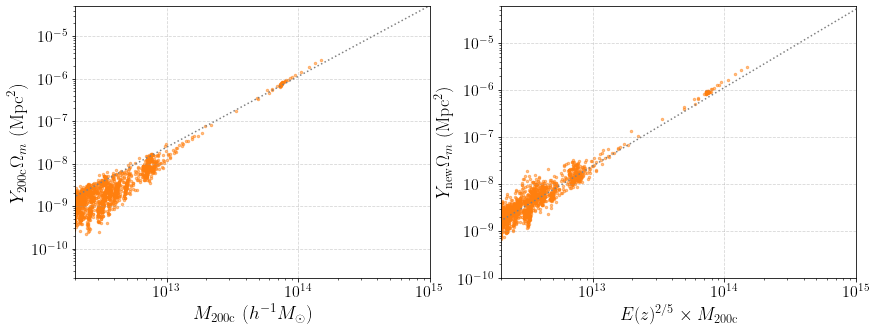

In [106]:
# 2.3 TNG, 2.5 SIMBA
plt.figure(figsize=(14,5))

plt.subplot(121)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log'); 
ax.scatter(m200*1e10,Y,alpha=.5,s=6,color='C1')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax.plot((powlaw**(3./5.))*3.7e17,powlaw,ls='dotted',color='gray')
plt.xlim(2e12,1e15); plt.ylim(2e-11,5e-5)
plt.xlabel(r'$M_\mathrm{200c}$'+'  ($h^{-1} M_\odot$)',fontsize=19); plt.ylabel(r'$Y_\mathrm{200c}\Omega_m \ (\mathrm{Mpc}^2)$',fontsize=19);

plt.subplot(122)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log'); 
ax.scatter(m200*1e10,Y*(1+(mStars2/mGas2)**1),alpha=.5,s=6,color='C1')
ax.plot((powlaw**(3./5.))*3.7e17,powlaw,ls='dotted',color='gray')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.xlim(2e12,1e15); plt.ylim(1e-10,6e-5)
plt.xlabel(r'$E(z)^{2/5} \times M_\mathrm{200c}$',fontsize=18); plt.ylabel(r'$Y_\mathrm{new}\Omega_m\ (\mathrm{Mpc}^2)$',fontsize=18);
#plt.savefig(plotdir+'trash/trash.pdf', bbox_inches='tight')

# Scatter plots

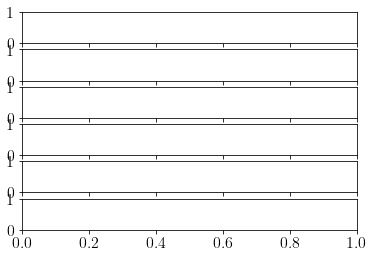

In [50]:
# Ignore output of this cell
labels=['$\Omega_m$','$\sigma_8$','$A_\mathrm{SN1}$','$A_\mathrm{AGN1}$','$A_\mathrm{SN2}$','$A_\mathrm{AGN2}$']
labels2=['$\Omega_m$','$\sigma_8$','$B_\mathrm{SN1}$','$B_\mathrm{AGN1}$','$B_\mathrm{SN2}$','$B_\mathrm{AGN2}$']
fig, axs = plt.subplots(6, sharex=True, sharey=True);

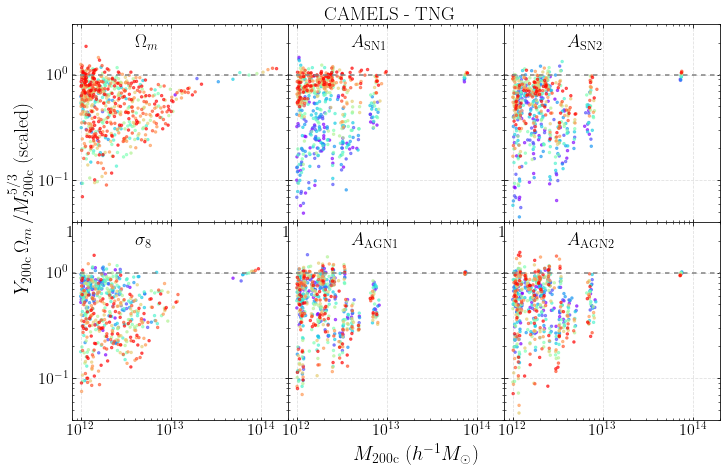

In [59]:
# This cell is only for TNG - 1P

if (key!='TNG' or key2!='1P'):
    raise Exception("This cell is only for TNG - 1P")

fig = plt.figure(num=None, figsize=(10, 5.5))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


axs[0] = fig.add_axes([0.05, .5, 0.3, 0.5], ylim=(4e-2,3),xlim=(0.8e12,2e14));
axs[1] = fig.add_axes([0.05, 0, 0.3, 0.5], ylim=(4e-2,3),xlim=(0.8e12,2e14)); 
axs[2] = fig.add_axes([0.35, .5, 0.3, 0.5], ylim=(4e-2,3),xlim=(0.8e12,2e14));
axs[3] = fig.add_axes([0.35, 0, 0.3, 0.5], ylim=(4e-2,3),xlim=(0.8e12,2e14)); 
axs[4] = fig.add_axes([0.65, .5, 0.3, 0.5], ylim=(4e-2,3),xlim=(0.8e12,2e14));
axs[5] = fig.add_axes([0.65, 0, 0.3, 0.5], ylim=(4e-2,3),xlim=(0.8e12,2e14)); 

for i in range(len(axs)):
    mask=index>=i*11; mask*=index<(i+1)*11
    axs[i].set_yscale('log'); axs[i].set_xscale('log');
    axs[i].plot(powlaw,np.ones(len(powlaw)),dashes=[3, 3],color='gray')
    if (i<2): 
        axs[i].scatter(m200[mask]*1e10,(Y/(m200**(5./3.))*3.7e12)[mask],alpha=.6,s=6,c=params[:,i][mask], cmap='rainbow')
        axs[i].tick_params(axis="both",direction="in",which='both',right='true',top='true')
    else:
        axs[i].scatter(m200[mask]*1e10,(Y/(m200**(5./3.))*3.7e12)[mask],alpha=.6,s=6,c=params[:,i][mask], cmap='rainbow',norm=matplotlib.colors.LogNorm())
        axs[i].tick_params(axis="both",direction="in",which='both',right='true',top='true', labelleft=0)
    axs[i].text(.4e13,1.8,labels[i],fontsize=18)
    axs[i].grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.3)

fig.text(0.4, 1.01, "CAMELS - TNG",fontsize=19)
fig.text(0.44, -0.1, r'$M_\mathrm{200c}$'+'  ($h^{-1} M_\odot$)',fontsize=20)
fig.text(-0.04, 0.33,r'$Y_\mathrm{200c}\, \Omega_m\, /M^{5/3}_\mathrm{200c}$   (scaled)',rotation=90,fontsize=20);
# plt.savefig(plotdir+'trash.png', bbox_inches='tight', dpi=150)

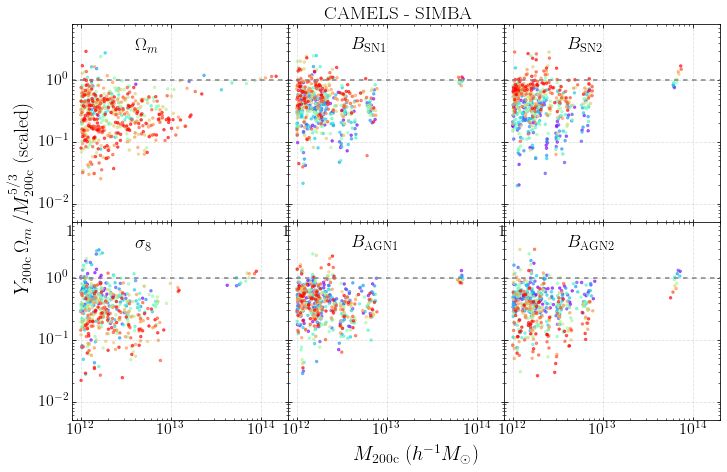

In [66]:
# SIMBA - 1P

fig = plt.figure(num=None, figsize=(10, 5.5))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


axs[0] = fig.add_axes([0.05, .5, 0.3, 0.5], ylim=(5e-3,8),xlim=(0.8e12,2e14));
axs[1] = fig.add_axes([0.05, 0, 0.3, 0.5], ylim=(5e-3,8),xlim=(0.8e12,2e14)); 
axs[2] = fig.add_axes([0.35, .5, 0.3, 0.5], ylim=(5e-3,8),xlim=(0.8e12,2e14));
axs[3] = fig.add_axes([0.35, 0, 0.3, 0.5], ylim=(5e-3,8),xlim=(0.8e12,2e14)); 
axs[4] = fig.add_axes([0.65, .5, 0.3, 0.5], ylim=(5e-3,8),xlim=(0.8e12,2e14));
axs[5] = fig.add_axes([0.65, 0, 0.3, 0.5], ylim=(5e-3,8),xlim=(0.8e12,2e14)); 

for i in range(len(axs)):
    mask=index>=i*11; mask*=index<(i+1)*11
    axs[i].set_yscale('log'); axs[i].set_xscale('log');
    axs[i].plot(powlaw,np.ones(len(powlaw)),dashes=[3, 3],color='gray')
    if (i<2): 
        axs[i].scatter(m200[mask]*1e10,(Y/(m200**(5./3.))*6e12)[mask],alpha=.6,s=6,c=params[:,i][mask], cmap='rainbow')
        axs[i].tick_params(axis="both",direction="in",which='both',right='true',top='true')
    else:
        axs[i].scatter(m200[mask]*1e10,(Y/(m200**(5./3.))*6e12)[mask],alpha=.6,s=6,c=params[:,i][mask], cmap='rainbow',norm=matplotlib.colors.LogNorm())
        axs[i].tick_params(axis="both",direction="in",which='both',right='true',top='true', labelleft=0)
    axs[i].text(.4e13,3,labels2[i],fontsize=18)
    axs[i].grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.3)

fig.text(0.4, 1.01, "CAMELS - SIMBA",fontsize=19)
fig.text(0.44, -0.1, r'$M_\mathrm{200c}$'+'  ($h^{-1} M_\odot$)',fontsize=20)
fig.text(-0.04, 0.33,r'$Y_\mathrm{200c}\, \Omega_m\, /M^{5/3}_\mathrm{200c}$   (scaled)',rotation=90,fontsize=20);
# plt.savefig(plotdir+'trash.png', bbox_inches='tight', dpi=150)

# Improving Y-M with machine learning

In [ ]:
# Use the LH set for this section

In [78]:
if (key == 'SIMBA'): NormFactor = 4.5e22
elif (key == 'TNG'): NormFactor = 3.4e22

M_over_Y= m200**(5./3.)*1e10/(Y*NormFactor) # Ratio in Eq. (5) of the paper

## Random forest

In [68]:
# The plots in this section were made for SIMBA

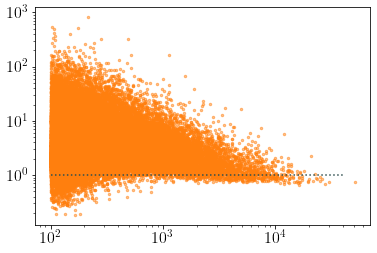

In [79]:
ax = plt.gca(); ax.set_xscale('log'); ax.set_yscale('log');
ax.scatter(m200 , M_over_Y, alpha=.5,s=6,color='C1')
ax.plot([1e2,4e4],[1,1],ls='dotted',color='darkslategray')

In [80]:
# Input array to RF
inp = np.zeros((len(m200),7))
inp[:,0] = mGas;
inp[:,1] = mStars;
inp[:,2] = mGas2/mGas
inp[:,3] = mStars2/mStars
# inp[:,4] = T500;
# inp[:,5] = Ngal; 
# inp[:,6] = Y
out = M_over_Y

In [81]:
maskTest = np.random.randint(len(inp),size=len(inp))>len(inp)/2

In [82]:
#Initializing RF
regr = RandomForestRegressor(max_depth=50, random_state=0,min_samples_leaf=5,n_estimators=50,n_jobs=-1)

#Fitting to training data
regr.fit(inp[~maskTest],log(out[~maskTest]),sample_weight=pow(m200,1/2)[~maskTest])

#Importance given by RF to each feature
print(regr.feature_importances_)

#metrics.mean_squared_error(regr.predict(inp[maskTest]),mtot[maskTest]/HODinv(Y)[maskTest])
# regrCopy = regr

[0.73637379 0.12948251 0.07303826 0.06110543 0.         0.
 0.        ]


In [83]:
mRatio = exp(regr.predict(inp[maskTest]))/out[maskTest];

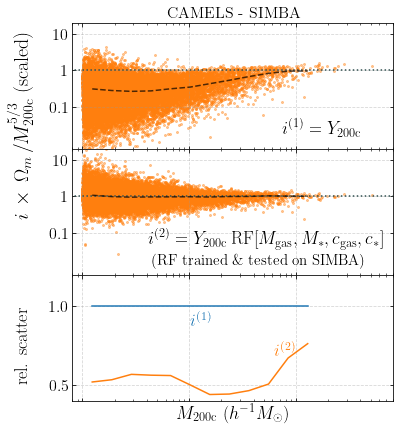

In [86]:
# We also test for generalization (training on SIMBA and testing on TNG)
temp=np.logspace(12.,14.2,num=13);
_ = m200[maskTest]*1e10
meanY=np.zeros((3,len(temp)-1)); stdY=meanY.copy(); temp2=sqrt(temp[:-1]*temp[1:]);

for i in range(len(temp)-1):
    mask = (_>=temp[i])*(_<=temp[i+1])
    meanY[0,i] = np.median(1/out[maskTest][mask]); meanY[1,i]=np.median(mRatio[mask]);
    stdY[0,i] = np.std(log10(1/out[maskTest][mask])); stdY[1,i]=np.std(log10(mRatio[mask]));

fig = plt.figure(num=None, figsize=(5.3, 7))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
ax1 = fig.add_axes([0.15, 0.65, 0.84, 0.25], ylim=(7e-3,2e1),xlim=(.8e12,.8e15));
ax2 = fig.add_axes([0.15, 0.4, 0.84, 0.25], ylim=(7e-3,2e1),xlim=(.8e12,.8e15));
ax3 = fig.add_axes([0.15, 0.15, 0.84, 0.25], ylim=(0.4,1.2),xlim=(.8e12,.8e15));
ax1.set_xscale('log'); ax2.set_xscale('log'); ax3.set_xscale('log');
ax1.set_yscale('log'); ax2.set_yscale('log');
ax1.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax2.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax3.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax1.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax2.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax3.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax1.set_yticks([1e-1,1,10]); ax2.set_yticks([1e-1,1,10]);
ax1.set_yticklabels(['0.1', '1', '10']); ax2.set_yticklabels(['0.1', '1', '10']);

ax1.plot([1e10,1e18],[1,1],ls='dotted',color='darkslategray')
ax1.scatter(_,1/out[maskTest],alpha=.4,s=4,color='C1')
ax1.plot(temp2,meanY[0],'--',color='black',alpha=0.7)
ax2.plot([1e10,1e18],[1,1],ls='dotted',color='darkslategray')
ax2.scatter(_,mRatio,alpha=.4,s=4,color='C1')
ax2.plot(temp2,meanY[1],'--',color='black',alpha=0.7)
ax3.plot(temp2,np.ones(len(temp2))); ax3.plot(temp2,stdY[1]/stdY[0]);

fig.text(0.7, 0.68, "$i^{(1)}= Y_\mathrm{200c}$", rotation=0,fontsize=18)
# fig.text(0.35, 0.45, r"$\frac{M^{5/3}_\mathrm{pred}}{Y_\mathrm{200c}\Omega_m}\propto\, RF[Y,M_\mathrm{gas},M_*,M_\mathrm{BH},c_\mathrm{gas}]$", rotation=0,fontsize=16)
fig.text(0.35, 0.46, r"$i^{(2)}=Y_\mathrm{200c}\, \mathrm{RF}[M_\mathrm{gas},M_*,c_\mathrm{gas},c_*]$", rotation=0,fontsize=18)
fig.text(0.36, 0.42, r"(RF trained \& tested on SIMBA)", rotation=0,fontsize=15)
fig.text(-0.02, 0.32+.2,r'$i\, \times\, \Omega_m\, /M^{5/3}_\mathrm{200c}$   (scaled)',fontsize=20,rotation=90);
fig.text(0.46, 0.05+.25, "$i^{(1)}$",fontsize=17,color='C0')
fig.text(0.68, -0.01+.25, "$i^{(2)}$",fontsize=17,color='C1')
fig.text(0, -0.01+.2,'rel. scatter',fontsize=18,rotation=90);
plt.xlabel(r'$M_\mathrm{200c}$'+'  ($h^{-1} M_\odot$)',fontsize=18);
fig.text(0.4, .91, "CAMELS - SIMBA",fontsize=16);
# plt.savefig(plotdir+'trash.png', bbox_inches='tight', dpi=300)

## Symbolic regression

In [87]:
# As PySR requires a bit of time to run, I export the datafile and
# run PySR separately on terminal (the code is in the following cell)

# run for LH set of SIMBA and TNG

_ = np.zeros((len(m200),5))
_[:,0] = M_over_Y;
_[:,1] = mGas
_[:,2] = mStars
_[:,3] = mGas2
_[:,3] = mStars2
_[:,4]=pow(m200,1/2);

if (key == 'TNG'):
    export_dataset_TNG = _.copy()

if (key == 'SIMBA'):
    export_dataset_SIMBA = _.copy()

In [215]:
export_dataset_combined = np.r_[export_dataset_TNG, export_dataset_SIMBA]
m200_combined = export_dataset_combined[:,4]**2

ind=[]
for i in range(len(m200_combined)):
    if(np.random.rand()<exp( (log10(m200_combined[i])-3.7)/.4 )):
        ind.append(i)
ind=np.array(ind); print(ind.shape)

export_dataset_downsampled = export_dataset_combined[ind]
np.save('/data/jayw/CCA/SyReg/Data/YM_Break.npy', export_dataset_downsampled)

(7600,)


In [ ]:
# Running PySR on terminal


import numpy as np
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power
from pysr import PySRRegressor

model.fit(X, y, weights=weights, variable_names=(var_names))

dire='/data/jayw/CCA/SyReg/Data/'
a=np.load(dire+'YM_Break.npy')
y = a[:,0] # M^{5/3}/Y
X = a[:,1:-1]

# Input variable names are
# mG: Mgas, mS: Mstars, mG2: Mgas within R200c/2
var_names = ['rSG', 'rSG2','rSG3']

# I use M_halo**0.5 as weights
# (because there are comparative many more
# low-mass halos in the sample)
weights = a[:,-1]


model = PySRRegressor(
    niterations=10,
    binary_operators=["+", "-", "*", "/",'pow'],
    unary_operators=["neg","exp","log10_abs"],
    #denoise=True,
    procs=7,
    model_selection="best",
    loss="loss(x, y, w) = abs(w * log(abs(x/y)))")

# Constraints on feedback params

In [96]:
import getdist
from getdist import plots, MCSamples

In [107]:
# Calculating mean Y in two different halo mass bins

# Run this cell and cell below for 1P set of both SIMBA and TNG
meanY_1Psims=np.zeros((4,11,4))

for i in range(0,4):
    for j in range(11):
        mask=index==((i+2)*11+j);
        mtemp=log10(m200[mask])
        Ytemp=Y[mask]/0.3 #Compensating for Omega_m
        
        mask=mtemp>2.5; mask*=mtemp<3.;
        meanY_1Psims[i,j,:2]=[mean(mtemp[mask]),log10(mean(Ytemp[mask]))]
        
        mask=mtemp>2; mask*=mtemp<2.5;
        meanY_1Psims[i,j,2:]=[mean(mtemp[mask]),log10(mean(Ytemp[mask]))]
        
if (key2=='1P'):
    if (key=='SIMBA'): meanY_SIMBA1P = meanY_1Psims.copy();
    elif (key=='TNG'): meanY_TNG1P = meanY_1Psims.copy();

In [108]:
# Calculating the log of the A(1), B(1) parameter combinations needed for Fig. 5

paramComb = np.zeros((4,11))
for i in range(0,4):
    for j in range(-5,6):
        if (key =='SIMBA'):
            if i==0: _ = 2*j*(-0.02)
            if i==1: _ = 2*j*-0.22
            if i==2: _ = j*-0.8
            if i==3: _ = j*0.55
        elif (key =='TNG'):
            if i==0: _ = 2*(j*-0.63)
            if i==1: _ = 2*(j*-0.04)
            if i==2: _ = j*-0.69
            if i==3: _ = j*0.34
            
        paramComb[i,j+5] = _
        
paramComb = (paramComb)/(amax(paramComb)-amin(paramComb))
if (key =='SIMBA'): SIMBAparamComb = paramComb + 0.7
if (key =='TNG'): TNGparamComb = paramComb + 2.1

In [118]:
# Forecast from Pandey et al. 20:

#mass-bin, log10(Y_mean(Mpc^2)), log10(Y_high(Mpc^2)). log10(Y_low(Mpc^2))
# 12.0-12.5, -8.27994314, -8.20254368, -8.35175797
# 12.5-13.0, -7.43994417, -7.39991039, -7.47232527
# 13.5-14.0,  -5.73582672, -5.72786395, -5.74175384

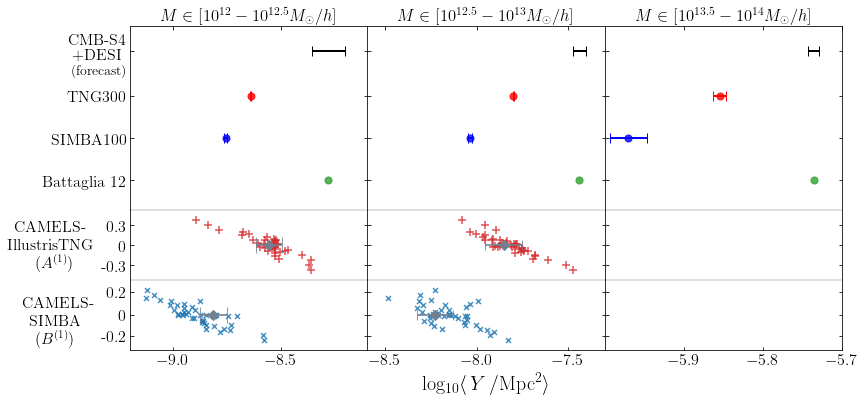

In [109]:
fig = plt.figure(num=None, figsize=(10, 5))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.0, 0.15, 0.33, 0.9], xlim=(-9.2,-8.1),ylim=(0.,6.5));
ax2 = fig.add_axes([0.33, 0.15, 0.33, 0.9], xlim=(-8.6,-7.3),ylim=(0.,6.5)); 
ax3 = fig.add_axes([0.66, 0.15, 0.33, 0.9], xlim=(-5.9999,-5.7),ylim=(0.,6.5));

ax1.tick_params(axis="both",direction="in",which='both',right='true',top='true')
ax2.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelleft=0)
ax3.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelleft=0)

#ax1.scatter(-(8.64+8.755)/2,6,alpha=.8,s=20,c='k')
ax1.errorbar(-8.28,6, xerr = 0.15/2, fmt = 'none',color = 'k', ecolor = 'k', elinewidth = 2, capsize=5)
ax1.scatter(-8.64,5.1,alpha=.8,s=50,c='r')
ax1.errorbar(-8.64,5.1, xerr = 0.0025, fmt = 'none',color = 'r', ecolor = 'r', elinewidth = 2, capsize=5)
ax1.scatter(-8.755,4.25,alpha=.8,s=50,c='blue')
ax1.errorbar(-8.755,4.25, xerr = 0.0075, fmt = 'none',color = 'blue', ecolor = 'blue', elinewidth = 2, capsize=5)
ax1.scatter(-8.27994314,3.4,alpha=.8,s=50,c='C2')
ax1.axhline(y=2.8,color='#999999',alpha=0.4); ax1.axhline(y=1.4,color='#999999',alpha=0.4);
ax1.scatter(np.ndarray.flatten(meanY_TNG1P[:,:,3]),np.ndarray.flatten(TNGparamComb),alpha=.8,s=50,c='tab:red',marker ="+")
ax1.scatter(meanY_TNG1P[1,5,3],2.1,alpha=1,s=50,c='slategray',marker ="D")
ax1.errorbar(meanY_TNG1P[1,5,3],2.1, xerr = 0.061, fmt = 'none',color = 'tab:red', ecolor = 'slategray', elinewidth = 2, capsize=8,alpha=0.8)
ax1.scatter(np.ndarray.flatten(meanY_SIMBA1P[:,:,3]),np.ndarray.flatten(SIMBAparamComb),alpha=.8,s=25,c='tab:blue',marker ="x")
ax1.scatter(meanY_SIMBA1P[1,5,3],.7,alpha=1,s=50,c='slategray',marker ="D")
ax1.errorbar(meanY_SIMBA1P[1,5,3],.7, xerr = 0.061, fmt = 'none',color = 'tab:blue', ecolor = 'slategray', elinewidth = 2, capsize=8,alpha=0.8)
ax1.set_yticks((.283,.7,1.17,1.7,2.1,2.5,3.4,4.25,5.1,6));
ax1.set_yticklabels(('-0.2','0','0.2','-0.3','0','0.3','Battaglia 12','SIMBA100','TNG300',''))
ax1.set_title(r'$M\in [10^{12}-10^{12.5}M_\odot/h]$');

#ax2.scatter(-(7.8+8.04)/2,6,alpha=.8,s=20,c='k')
ax2.errorbar(-7.44,6, xerr = 0.072/2, fmt = 'none',color = 'k', ecolor = 'k', elinewidth = 2, capsize=5)
ax2.scatter(-7.8,5.1,alpha=.8,s=50,c='r')
ax2.errorbar(-7.8,5.1, xerr = 0.0037, fmt = 'none',color = 'r', ecolor = 'r', elinewidth = 2, capsize=5)
ax2.scatter(-8.04,4.25,alpha=.8,s=50,c='blue')
ax2.errorbar(-8.04,4.25, xerr = 0.011, fmt = 'none',color = 'blue', ecolor = 'blue', elinewidth = 2, capsize=5)
ax2.scatter(-7.43994417,3.4,alpha=.8,s=50,c='C2')
ax2.axhline(y=2.8,color='#999999',alpha=0.4); ax2.axhline(y=1.4,color='#999999',alpha=0.4);
ax2.scatter(np.ndarray.flatten(meanY_TNG1P[:,:,1]),np.ndarray.flatten(TNGparamComb),alpha=.8,s=50,c='tab:red',marker ="+")
ax2.scatter(meanY_TNG1P[1,5,1],2.1,alpha=1,s=50,c='slategray',marker ="D")
ax2.errorbar(meanY_TNG1P[1,5,1],2.1, xerr = 0.0989, fmt = 'none',color = 'tab:red', ecolor = 'slategray', elinewidth = 2, capsize=5,alpha=0.8)
ax2.scatter(np.ndarray.flatten(meanY_SIMBA1P[:,:,1]),np.ndarray.flatten(SIMBAparamComb),alpha=.8,s=25,c='tab:blue',marker ="x")
ax2.errorbar(meanY_SIMBA1P[3,5,1],.7, xerr = 0.0989, fmt = 'none',color = 'tab:blue', ecolor = 'slategray', elinewidth = 2, capsize=5,alpha=0.8)
ax2.scatter(meanY_SIMBA1P[3,5,1],.7,alpha=1,s=50,c='slategray',marker ="D")
ax2.set_yticks((.283,.7,1.17,1.7,2.1,2.5,3.4,4.25,5.1,6));
ax2.set_title(r'$M\in [10^{12.5}-10^{13}M_\odot/h]$');
ax2.set_xlabel(r'log$_{10}\langle\, Y\, /\mathrm{Mpc}^2 \rangle$',fontsize=20);

#ax3.scatter(-(5.855+5.97)/2,6,alpha=.8,s=20,c='k')
ax3.errorbar(-5.736,6, xerr = 0.014/2, fmt = 'none',color = 'k', ecolor = 'k', elinewidth = 2, capsize=5)
ax3.scatter(-5.855,5.1,alpha=.8,s=50,c='r')
ax3.errorbar(-5.855,5.1, xerr = 0.00787, fmt = 'none',color = 'r', ecolor = 'r', elinewidth = 2, capsize=5)
ax3.scatter(-5.97,4.25,alpha=.8,s=50,c='blue')
ax3.errorbar(-5.97,4.25, xerr = 0.0231, fmt = 'none',color = 'blue', ecolor = 'blue', elinewidth = 2, capsize=5)
ax3.scatter(-5.73582672,3.4,alpha=.8,s=50,c='C2')
ax3.axhline(y=2.8,color='#999999',alpha=0.4); ax3.axhline(y=1.4,color='#999999',alpha=0.4);
ax3.set_title(r'$M\in [10^{13.5}-10^{14}M_\odot/h]$');
ax3.set_yticks((.283,.7,1.17,1.7,2.1,2.5,3.4,4.25,5.1,6));
fig.text(-0.085, 1., 'CMB-S4', rotation=0,fontsize=16)
fig.text(-0.08, .955, '+DESI', rotation=0,fontsize=16)
fig.text(-0.08, .915, '(forecast)', rotation=0,fontsize=14)
fig.text(-0.16, .48, 'CAMELS-', rotation=0,fontsize=16)
fig.text(-0.17, .43, 'IllustrisTNG', rotation=0,fontsize=16)
fig.text(-0.13, .38, '$(A^{(1)})$', rotation=0,fontsize=16)
fig.text(-0.15, .27, 'CAMELS-', rotation=0,fontsize=16)
fig.text(-0.14, .22, 'SIMBA', rotation=0,fontsize=16)
fig.text(-0.13, .17, '$(B^{(1)})$', rotation=0,fontsize=16);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight')

In [ ]:
# Now calculating derivatives of Y w.r.t parameters

In [110]:
# We will ignore the few bins on the edges and use the central bins
meanY_SIMBA1P = meanY_SIMBA1P[:,2:-2,:]
meanY_TNG1P = meanY_TNG1P[:,2:-2,:]

In [111]:
derivSIMBA, derivTNG = np.zeros((2,4,4))
#Ytruth=saveFit[0,2]

for i in range(4):
    _ = meanY_SIMBA1P[i]
    #deriv[i]=(_[4]-_[2])/2.
#     deriv[i]=(8*(_[4]-_[2]) - (_[5]-_[1]) )/12
    derivSIMBA[i]= (45*(_[4]-_[2]) - 9*(_[5]-_[1]) + (_[6]-_[0]) )/60
    _ = meanY_TNG1P[i]
    derivTNG[i]= (45*(_[4]-_[2]) - 9*(_[5]-_[1]) + (_[6]-_[0]) )/60
    
derivSIMBA = derivSIMBA[:,np.array([1,3])]
derivSIMBA[:2] /= 0.12; derivSIMBA[2:] /= 0.06
derivTNG = derivTNG[:,np.array([1,3])]
derivTNG[:2] /= 0.12; derivTNG[2:] /= 0.06

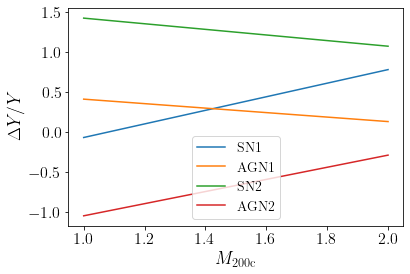

In [112]:
_ = derivSIMBA
plot=np.arange(1,3)
plt.plot(plot, _[0])
plt.plot(plot, _[1])
plt.plot(plot, _[2])
plt.plot(plot, _[3])
plt.xlabel(r'$M_\mathrm{200c}$',fontsize=18); plt.ylabel(r'$\Delta Y/Y$',fontsize=18)
plt.legend(['SN1','AGN1','SN2','AGN2'])

In [113]:
# Constructing the covariance matrix using values from Pandey et al. 20 forecast
covMat=np.zeros((2,2));
covMat[0,0]=(.072/2)**2; covMat[1,1]=(.15/2)**2

prior=np.diag(np.ones(4)*(1/1)**2) # Gaussian prior on the diagonals

In [114]:
it=4;
FisherSIMBA, FisherTNG =np.zeros((2,it,it));
for i in range(it): 
    for j in range(it):
        FisherSIMBA[i,j]=dot(dot(derivSIMBA[i],np.linalg.inv(covMat)),derivSIMBA[j])
        FisherTNG[i,j]=dot(dot(derivTNG[i],np.linalg.inv(covMat)),derivTNG[j])

FisherSIMBA += prior; FisherTNG += prior; 

In [115]:
FisherSIMBA

array([[  113.02566356,    -3.19526548,    74.85520248,    14.55788547],
       [   -3.19526548,   134.96882301,   477.87220021,  -339.29030293],
       [   74.85520248,   477.87220021,  1772.04400222, -1205.28075625],
       [   14.55788547,  -339.29030293, -1205.28075625,   860.66221464]])

In [116]:
w,v=np.linalg.eigh(FisherSIMBA-prior)
print(w); v.round(2)

[-5.87826118e-13 -1.48103661e-13  1.39808151e+02  2.73689255e+03]


array([[ 0.38,  0.25,  0.89, -0.02],
       [ 0.71, -0.66, -0.12, -0.22],
       [-0.46, -0.28,  0.26, -0.8 ],
       [-0.38, -0.65,  0.35,  0.55]])

In [117]:
1/sqrt(w)/log(10)

/var/folders/7w/89d6ngyd65x1jws5v2ww6_kh0000gq/T/ipykernel_82184/3148772097.py:1: RuntimeWarning: invalid value encountered in sqrt
  1/sqrt(w)/log(10)


array([       nan,        nan, 0.03672976, 0.00830148])

In [118]:
g = plots.getSubplotPlotter(width_inch=8)
g.settings.alpha_filled_add = 0.8
g.settings.shade_level_scale = 2
g.settings.figure_legend_frame = False
g.settings.legend_fontsize = 24
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 23
g.settings.x_label_rotation = 45
g.settings.lw1 = 2
g.settings.lw_contour = 1.3

In [119]:
ndim = it
nsamp = 10000
np.random.seed(4)
samps = np.random.multivariate_normal([0]*ndim, np.linalg.inv(FisherSIMBA), size=nsamp)

In [120]:
names = ['SN1','AGN1','SN2','AGN2']
# labels = ['A_\mathrm{SN1}','A_\mathrm{AGN1}','A_\mathrm{SN2}','A_\mathrm{AGN2}']
labels = ['B_\mathrm{SN1}','B_\mathrm{AGN1}','B_\mathrm{SN2}','B_\mathrm{AGN2}']
samples = MCSamples(samples=samps,names = names, labels = labels)

Removed no burn in


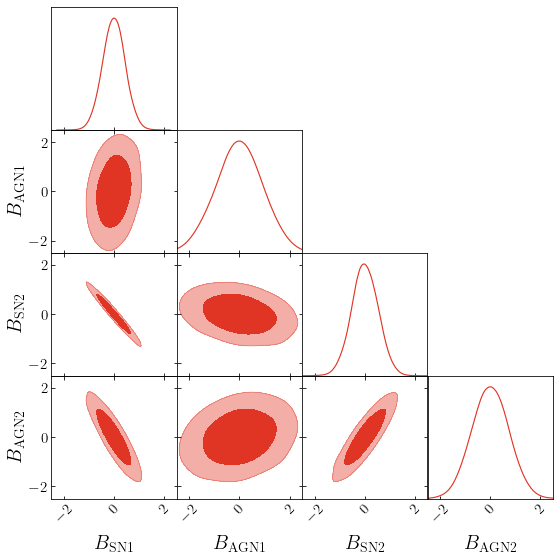

In [121]:
g.triangle_plot([samples],
                param_limits={'SN1':[-2.5,2.5],'AGN1':[-2.5,2.5],'SN2':[-2.5,2.5],'AGN2':[-2.5,2.5]},
                filled=True,
                #legend_labels=['$Y$-$M$ relation', 'Spectral distortions', 'Combined'],
                #markers={'SN1':-2,'SN2':2},
                colors=['#E03424','gray','#006FED'],
                line_args=[{'color':'#E03424'}]
               )
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight')

In [122]:
Fisher2D=np.diag(np.array([2.73789255e+03,1.40808151e+02]))
# VarPar=np.diag([1.21003390e+03,3.89169067e+01])
np.random.seed(10)
samps = np.random.multivariate_normal([0]*2, np.linalg.inv(Fisher2D), size=10000)
names = ['B_1','B_2']
labels = ['B^{(1)}_\mathrm{SIMBA}','B^{(2)}_\mathrm{SIMBA}']
# labels = ['A^{(1)}_\mathrm{TNG}','A^{(2)}_\mathrm{TNG}']
samples = MCSamples(samples=samps,names = names, labels = labels)

Removed no burn in


In [123]:
g = plots.getSubplotPlotter(width_inch=5)
g.settings.alpha_filled_add = 0.8
g.settings.shade_level_scale = 2
g.settings.figure_legend_frame = False
g.settings.legend_fontsize = 24
g.settings.axes_fontsize = 25
g.settings.lab_fontsize = 25
g.settings.x_label_rotation = 45
g.settings.lw1 = 2
g.settings.lw_contour = 1.3

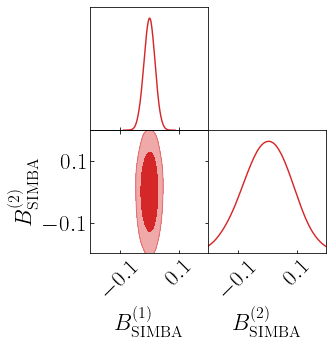

In [124]:
# g.triangle_plot([samples],legend_labels=[r'TNG'], filled=True,colors=['C1'],line_args=[{'color':'C1'}])
g.triangle_plot([samples],
                param_limits={'B_1':[-.2,.2],'B_2':[-.2,.2]},filled=True,
                colors=['C3'],line_args=[{'color':'C3'}])
#                 colors=['C1'],line_args=[{'color':'C1'}])
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight')

In [125]:
# Fisher matrix from Thiele et al. 22 for CMB spectral distortions

#IllustrisTNG:
Fisher_SD_TNG =  np.array( [[ 184.90280882,  119.40199691,  705.11907304,  540.65437696],
  [ 119.40199717,   77.21812185,  455.73820316,  349.72149534],
  [ 705.11907394,  455.73820277, 2690.37623782, 2063.86237908],
  [ 540.65437829,  349.72149545, 2063.86238149, 1583.94283859]])

#SIMBA:
# Fisher_SD_SIMBA = np.array([[  5208.03301476,  -9262.03696558,  21883.97513467, -18443.01412549],
#   [ -9262.03698568,  16496.81501291, -39010.88073108,  32948.19470825],
#   [ 21883.9752085,  -39010.88077792,  92294.04738047, -78043.73628216],
#   [-18443.01424482,  32948.19484927, -78043.73652211,  66195.35064562]])

Fisher_SD_TNG /= log(10)**2
Fisher = FisherTNG + Fisher_SD_TNG